In [8]:
import pandas as pd
import configparser
import requests
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
import time

In [2]:
# Load credentials from config file
config = configparser.ConfigParser()
config.read('pyalgo.cfg')

consumer_id = config['ssi']['ConsumerID']
consumer_secret = config['ssi']['ConsumerSecret']
private_key = config['ssi']['PrivateKey']

In [3]:
# Step 1: Request access token
def get_access_token(consumer_id, consumer_secret, private_key):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/AccessToken"
    headers = {"Content-Type": "application/json"}
    data = {
        "consumerID": consumer_id,
        "consumerSecret": consumer_secret,
        "privateKey": private_key
    }
    res = requests.post(url, json=data, headers=headers)
    res.raise_for_status()
    response = res.json()

    # Extract access token from response
    if "data" in response and "accessToken" in response["data"]:
        return response["data"]["accessToken"]
    else:
        raise ValueError("Access token not found in response:", response)

# Step 2: Get stock price using access token
def get_stock_price(symbol, token, start_date, end_date):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/DailyStockPrice"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
        "Symbol": symbol,
        "FromDate": start_date,
        "ToDate": end_date,
        "Market": "HOSE",
        "PageIndex": "1",
        "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [4]:
# Define token
token = get_access_token(consumer_id, consumer_secret, private_key)

In [5]:
stock = pd.DataFrame(columns=['TradingDate', 'ClosePrice'])

# Historical data

In [6]:
symb = 'GAS'
date = datetime.today()

for i in range(20):
    end_date = date.strftime("%d/%m/%Y")
    start_date = (date - timedelta(days=30)).strftime("%d/%m/%Y")
    data = get_stock_price(symb, token, start_date, end_date)
    df = pd.DataFrame(data['data'])

    # Ensure correct types
    df['TradingDate'] = pd.to_datetime(df['TradingDate'], dayfirst=True)
    df['ClosePrice'] = pd.to_numeric(df['ClosePrice'], errors='coerce')
    
    df1 = df.loc[df['Symbol'] == symb, ['TradingDate', 'ClosePrice']]

    # Append to master DataFrame
    stock = pd.concat([stock, df1], ignore_index=True)

    # Adjust date back
    date -= timedelta(days=31)

    # Wait before the next request to respect rate limit
    time.sleep(3)  

/tmp/ipykernel_33364/3811047364.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock = pd.concat([stock, df1], ignore_index=True)


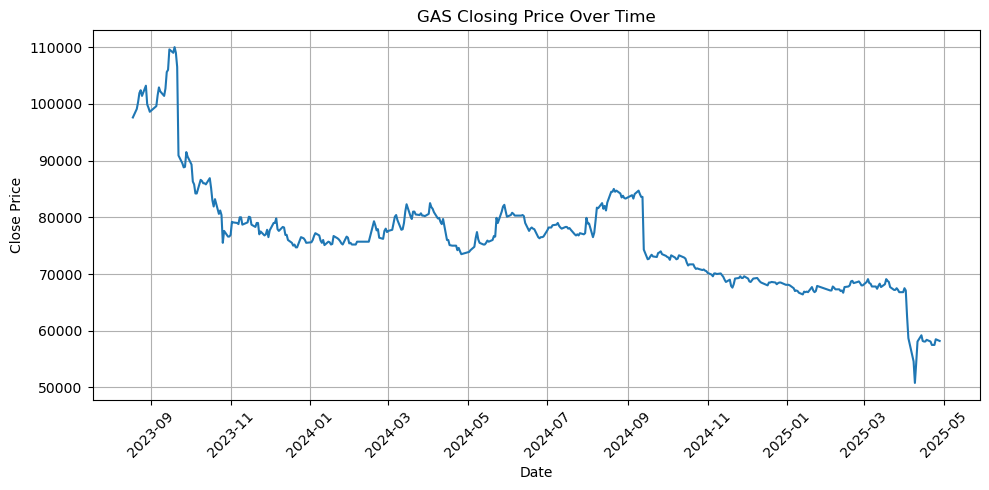

In [7]:
# Sort by trading date
stock = stock.sort_values('TradingDate')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stock['TradingDate'], stock['ClosePrice'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{symb} Closing Price Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
stock

,TradingDate,ClosePrice
420,2023-08-18,97600
419,2023-08-21,99100
418,2023-08-22,100300
417,2023-08-23,101900
416,2023-08-24,102400
...,...,...
4,2025-04-22,57500
3,2025-04-23,57500
2,2025-04-24,57500
1,2025-04-25,58500


# Realtime data

In [9]:
# Get realtime stock price and info
def get_rt_stock_price(symbol, token):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/IntradayOhlc"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
    "symbol": symbol,
    "FromDate": datetime.today().strftime("%d/%m/%Y"),
    "ToDate": datetime.today().strftime("%d/%m/%Y"),
    "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [10]:
rt_stock = get_rt_stock_price('GAS', token)

In [11]:
rt_stock = pd.DataFrame(data['data'])
rt_stock

,TradingDate,PriceChange,PerPriceChange,CeilingPrice,FloorPrice,RefPrice,OpenPrice,HighestPrice,LowestPrice,ClosePrice,...,TotalBuyTrade,TotalBuyTradeVol,TotalSellTrade,TotalSellTradeVol,NetBuySellVol,NetBuySellVal,TotalTradedVol,TotalTradedValue,Symbol,Time
0,15/09/2023,3600,3.40,113400,98600,106000,107000,109700,106100,109600,...,0,0,0,0,225230,24662685000,793000,86070769999.9999,GAS,None
1,14/09/2023,400,0.40,112900,98300,105600,105600,107900,104500,106000,...,0,0,0,0,11600,1241200000,552900,58646700000,GAS,None
2,13/09/2023,2900,2.80,109800,95600,102700,103100,106300,102700,105600,...,0,0,0,0,-43480,-4587140000,1296300,135360020000.0010,GAS,None
3,12/09/2023,1300,1.30,108400,94400,101400,102200,103600,101100,102700,...,0,0,0,0,-163230,-16812690000,588800,60542400000,GAS,None
4,11/09/2023,-800,-0.80,109300,95100,102200,103500,103500,101100,101400,...,0,0,0,0,-11250,-1141875000,371800,37938979999.9999,GAS,None
5,08/09/2023,-700,-0.70,110100,95700,102900,102900,103300,102200,102200,...,0,0,0,0,-1730,-176806000,548900,56559499999.9999,GAS,None
6,07/09/2023,1400,1.40,108600,94400,101500,101400,103200,100600,102900,...,0,0,0,0,139365,14340658500,911900,93210230000.0003,GAS,None
7,06/09/2023,1900,1.90,106500,92700,99600,99900,101800,99700,101500,...,0,0,0,0,-2101,-213251500,547900,55200789999.9999,GAS,None
8,05/09/2023,1000,1,105500,91700,98600,100200,100200,98700,99600,...,0,0,0,0,-19400,-1932240000,420600,41918300000,GAS,None
9,31/08/2023,-700,-0.70,106200,92400,99300,99300,99500,98600,98600,...,0,0,0,0,-229400,-22618840000,573700,56753610000,GAS,None


In [12]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(rt_stock['Time'], rt_stock['Close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'GAS Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

KeyError: 'Close'

<Figure size 1000x500 with 0 Axes>

In [13]:
t = None
while True:
    rt = get_rt_stock_price('GAS', token)
    if t == None or rt['data'][0]['Time'] != t:
        print(rt['data'][0])
    t = rt['data'][0]['Time']
    time.sleep(2)

{'Symbol': 'GAS', 'Value': '58200', 'TradingDate': '28/04/2025', 'Time': '13:34:32', 'Open': '58200', 'High': '58200', 'Low': '58200', 'Close': '58200', 'Volume': '1000'}
{'Symbol': 'GAS', 'Value': '58200', 'TradingDate': '28/04/2025', 'Time': '13:36:16', 'Open': '58200', 'High': '58200', 'Low': '58200', 'Close': '58200', 'Volume': '300'}
{'Symbol': 'GAS', 'Value': '58200', 'TradingDate': '28/04/2025', 'Time': '13:36:49', 'Open': '58200', 'High': '58200', 'Low': '58200', 'Close': '58200', 'Volume': '600'}
{'Symbol': 'GAS', 'Value': '58200', 'TradingDate': '28/04/2025', 'Time': '13:37:50', 'Open': '58200', 'High': '58200', 'Low': '58200', 'Close': '58200', 'Volume': '300'}
{'Symbol': 'GAS', 'Value': '58200', 'TradingDate': '28/04/2025', 'Time': '13:38:06', 'Open': '58200', 'High': '58200', 'Low': '58200', 'Close': '58200', 'Volume': '1100'}
{'Symbol': 'GAS', 'Value': '58200', 'TradingDate': '28/04/2025', 'Time': '13:38:24', 'Open': '58200', 'High': '58200', 'Low': '58200', 'Close': '582

KeyboardInterrupt: 

In [ ]:
fig = go.FigureWidget()
fig.add_scatter()
fig

In [ ]:
times = list()
prices = list()

for _ in range(75):
    rt = get_rt_stock_price('GAS', token)
    t = rt['data'][0]['Time']
    times.append(t)  
    price = rt['data'][0]['Close']
    prices.append(int(price))
    fig.data[0].x = times  
    fig.data[0].y = prices  
    time.sleep(2)

In [6]:
from vnstock import Vnstock
stock = Vnstock().stock(symbol='GAS', source='VCI')
stk = stock.quote.history(start='2022-01-01', end='2025-05-28', to_df=True)
stk.tail()

,time,open,high,low,close,volume
821,2025-04-23,58.1,58.6,57.4,57.5,698300
822,2025-04-24,57.5,58.0,57.3,57.5,410200
823,2025-04-25,57.6,58.5,57.5,58.5,913600
824,2025-04-28,58.4,58.5,58.1,58.4,271300
825,2025-04-29,58.4,58.4,58.2,58.4,202300


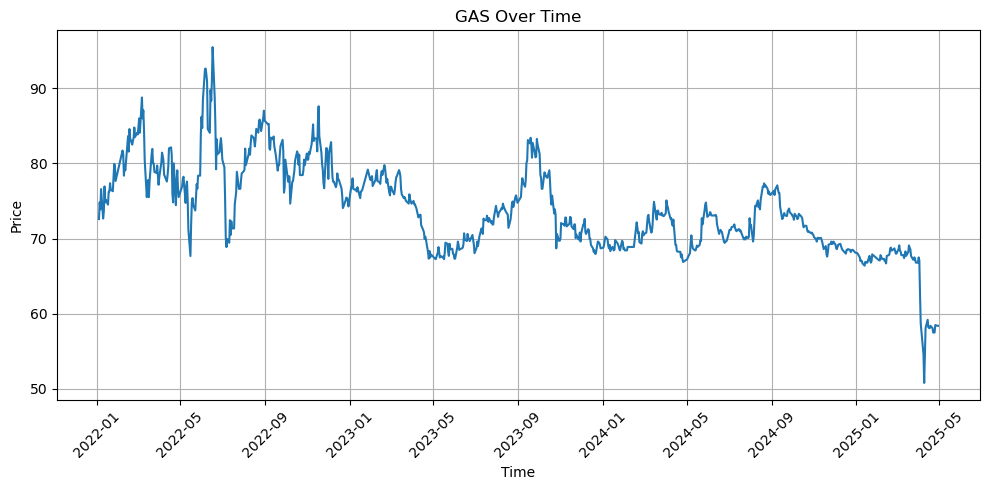

In [10]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(stk['time'], stk['close'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'GAS Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
stock.quote.intraday(symbol='VCB').tail()

,time,price,volume,match_type,id
95,2025-04-29 13:59:20+07:00,57700.0,100,Buy,292985666
96,2025-04-29 13:59:20+07:00,57700.0,100,Buy,292985670
97,2025-04-29 14:00:02+07:00,57600.0,2200,Sell,292986734
98,2025-04-29 14:00:02+07:00,57600.0,500,Sell,292986735
99,2025-04-29 14:00:03+07:00,57600.0,4000,Sell,292986756
